# 03 - EDA

In [1]:
import sys
sys.executable

'/usr/local/bin/python'

## Imports

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import stock_utils.constants as cnst
import stock_utils.data as sd
from stock_utils.metrics import adam_momentum

pd.set_option('display.max_columns', None)

NSE_DATA_DIR = PosixPath('../data/NSE') | Valid: True
SCREENER_EPS_DATA_DIR = PosixPath('../data/Screener.in/EPS') | Valid: True
PROCESSED_DATA_DIR = PosixPath('../data/processed') | Valid: True


## Constants

In [3]:
stock_symbols = sd.get_all_stock_symbols(
    cnst.NSE_DATA_DIR
)

stock_symbols

['DEEPAKFERT', 'HDFCBANK', 'INDIGOPNTS', 'ITBEES', 'JUBLFOOD', 'NH']

In [4]:
STOCK_SYMBOL = stock_symbols[1]

STOCK_SYMBOL

'HDFCBANK'

## Data loading

### Stock data

In [5]:
stock_data = sd.StockData(STOCK_SYMBOL)
stock_data

Symbol: HDFCBANK
Total records: 1097
First record: 2020-01-01
Last record: 2024-05-09

## Statistical analysis

### Historical

#### Stock `Close` price

##### Cumulative distribution and quantiles

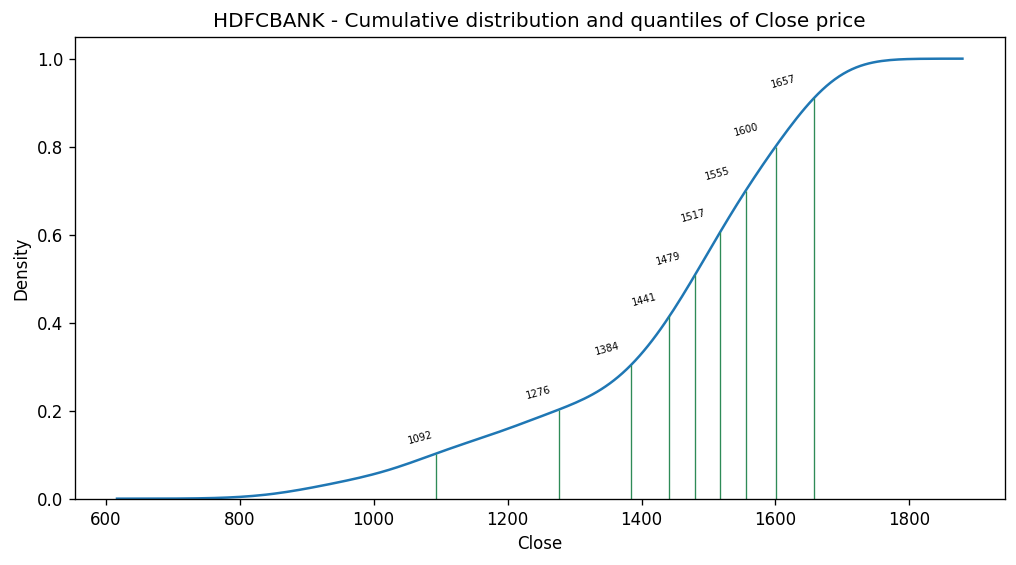

In [6]:
plt.figure(figsize = (10, 5), dpi = 120)

kde_data_x, kde_data_y = sns.kdeplot(
    data = stock_data.processed,
    x = "Close",
    cumulative = True
).lines[0].get_data()

for q in [i/10 for i in range(1, 10)]:
    kde_x, kde_y = kde_data_x[kde_data_y > q][0], kde_data_y[kde_data_y > q][0]

    plt.vlines(
        x = kde_x,
        ymin = 0,
        ymax = kde_y,
        linestyles = "solid",
        colors = "seagreen",
        linewidth = 0.8
    )

    plt.text(
        kde_x * 0.96, 
        kde_y + 0.024, 
        int(kde_x),
        fontsize = 6,
        rotation = 15
    )

plt.title(f"{STOCK_SYMBOL} - Cumulative distribution and quantiles of Close price")
plt.show()

#### Candle type

##### Overall proportion

In [7]:
stock_data.processed['IsGreen'].value_counts(normalize = True).mul(100).round(2)

IsGreen
1    51.6
0    48.4
Name: proportion, dtype: float64

##### By year

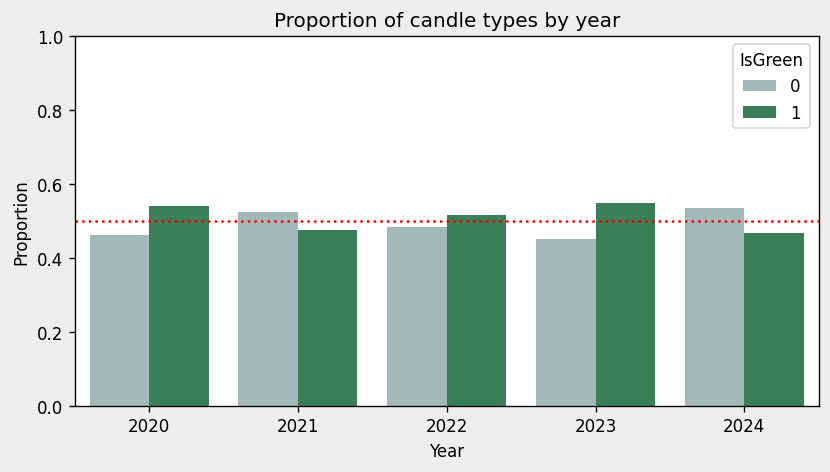

In [8]:
plt.figure(figsize = (8, 4), dpi = 120, facecolor = "#eee")
sns.barplot(
    data = stock_data.processed.groupby(
        'Year', as_index = False
    )['IsGreen'].value_counts(normalize = True),
    x = "Year",
    y = "proportion",
    hue = "IsGreen",
    palette = "blend:#9fbcbb,seagreen"
)
plt.hlines(y = 0.5, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.ylim((0, 1))
plt.xlim((
    -0.5, 
    stock_data.processed['Year'].max() - stock_data.processed['Year'].min() + 0.5
))
plt.ylabel("Proportion")
plt.title("Proportion of candle types by year")
plt.show()

##### By quarter

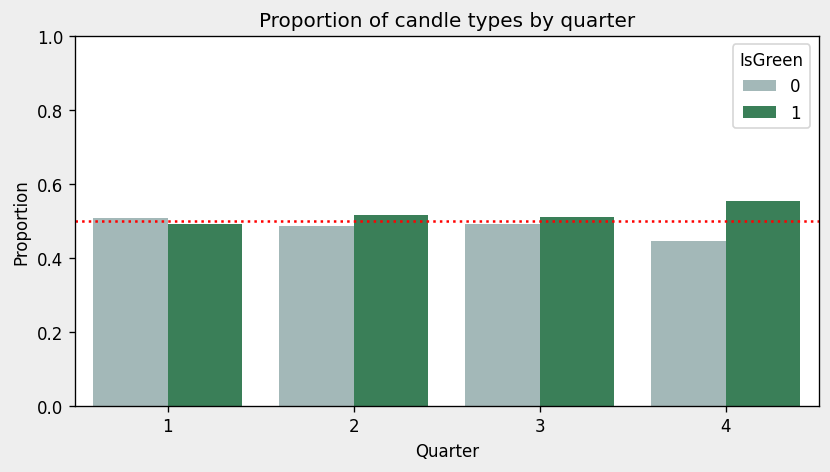

In [9]:
plt.figure(figsize = (8, 4), dpi = 120, facecolor = "#eee")
sns.barplot(
    data = stock_data.processed.groupby(
        'Quarter', as_index = False
    )['IsGreen'].value_counts(normalize = True),
    x = "Quarter",
    y = "proportion",
    hue = "IsGreen",
    palette = "blend:#9fbcbb,seagreen"
)
plt.hlines(y = 0.5, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.ylim((0, 1))
plt.xlim((-0.5, 3.5))
plt.ylabel("Proportion")
plt.title("Proportion of candle types by quarter")
plt.show()

#### Normalized Range

##### Overall distribution

In [10]:
stock_data.processed['NR'] = (
    (
        stock_data.processed['Close'] - stock_data.processed['Open']
    ) / stock_data.processed['Open']
) * 100

stock_data.processed[['NR']].describe().round(2)

,NR
count,1097.00
mean,-0.04
std,1.49
min,-10.97
25%,-0.76
50%,-0.02
75%,0.67
max,11.20


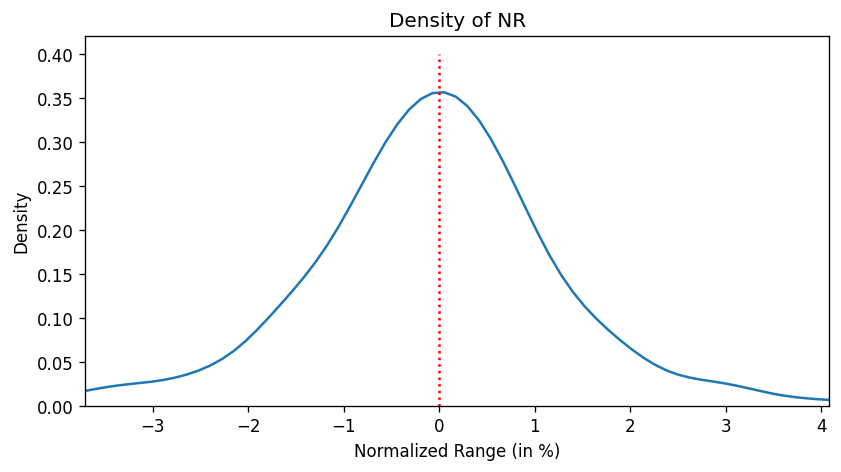

In [11]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.kdeplot(
    stock_data.processed['NR']
)
plt.vlines(x = 0, ymin = 0, ymax = 0.4, linestyles = "dotted", colors = "red")
plt.xlabel("Normalized Range (in %)")
plt.title("Density of NR")
plt.xlim((
    stock_data.processed['NR'].quantile(0.01),
    stock_data.processed['NR'].quantile(0.99)
))
plt.show()

##### By candle type

In [12]:
stock_data.processed.groupby('IsGreen')[['NR']].describe().round(2)

NR                                            
         count  mean   std    min   25%   50%   75%    max
IsGreen                                                   
0        531.0 -0.94  1.17 -10.97 -1.47 -0.72 -0.22   1.72
1        566.0  0.80  1.25  -4.29  0.12  0.58  1.22  11.20

##### By year

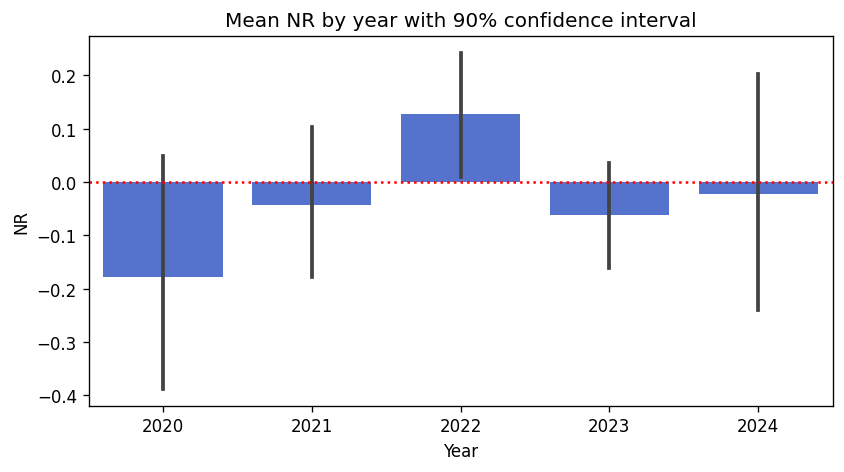

In [13]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.barplot(
    data = stock_data.processed,
    x = "Year",
    y = "NR",
    estimator = "mean",
    errorbar = ("ci", 90),
    color = "royalblue"
)
plt.hlines(y = 0, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.title(r"Mean NR by year with 90% confidence interval")
plt.xlim((
    -0.5, 
    stock_data.processed['Year'].max() - stock_data.processed['Year'].min() + 0.5
))
plt.show()

##### By quarter

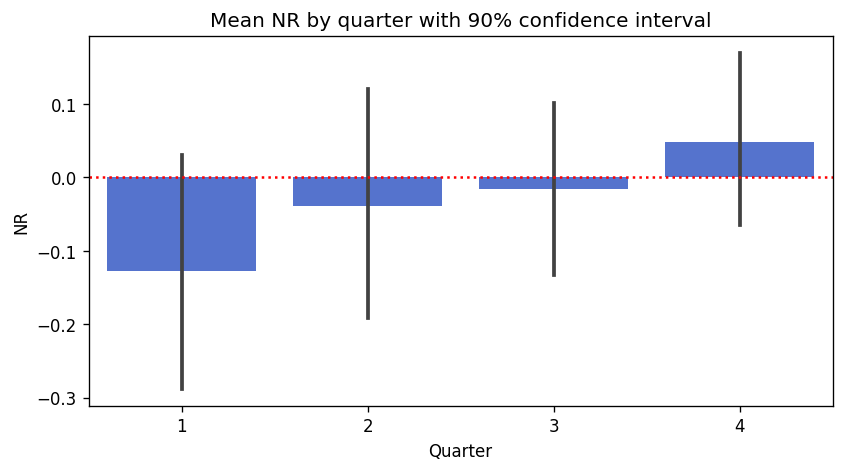

In [14]:
plt.figure(figsize = (8, 4), dpi = 120)
sns.barplot(
    data = stock_data.processed,
    x = "Quarter",
    y = "NR",
    estimator = "mean",
    errorbar = ("ci", 90),
    color = "royalblue"
)
plt.hlines(y = 0, xmin = -0.5, xmax = 5, linestyles = "dotted", colors = "red")
plt.title(r"Mean NR by quarter with 90% confidence interval")
plt.xlim((-0.5, 3.5))
plt.show()

#### Streak

##### Current and max streak

In [15]:
def get_streak_info(streak_id: int):
    streak_filter = stock_data.processed['StreakIndex'] == streak_id
    streak_count = streak_filter.sum()
    is_green = stock_data.processed['IsGreenStreak'][streak_filter].iloc[0]
    streak_start = stock_data.processed["Date"][streak_filter].min().strftime("%Y-%m-%d")
    streak_end = stock_data.processed["Date"][streak_filter].max().strftime("%Y-%m-%d")

    return streak_count, is_green, streak_start, streak_end

stock_data.processed["StreakIndex"] = (
    stock_data.processed["IsGreen"] != stock_data.processed["IsGreen"].shift(1)
).cumsum()
stock_data.processed["IsGreenStreak"] = (
    stock_data.processed.groupby("StreakIndex")["IsGreen"].transform('sum') > 0
)
g_streak_filter = stock_data.processed["IsGreenStreak"]

max_green_streak = get_streak_info(
    stock_data.processed[
        g_streak_filter
    ].groupby("StreakIndex")["Date"].count().sort_values().index[-1]
)
max_red_streak = get_streak_info(
    stock_data.processed[
        ~g_streak_filter
    ].groupby("StreakIndex")["Date"].count().sort_values().index[-1]
)
cur_streak = get_streak_info(stock_data.processed['StreakIndex'].max())

print(f"Total streaks: {stock_data.processed['StreakIndex'].max()}")
print(f"Green streaks: {stock_data.processed[g_streak_filter]['StreakIndex'].nunique()}")
print(f"\nMax green streak: {max_green_streak[0]}")
print(f"From {max_green_streak[2]} to {max_green_streak[3]}")
print(f"\nMax red streak: {max_red_streak[0]}")
print(f"From {max_red_streak[2]} to {max_red_streak[3]}")
print(f"\nCurrent streak: {cur_streak[0]}")
print(f"Is green: {cur_streak[1]}")
print(f"From {cur_streak[2]} to {cur_streak[3]}")

Total streaks: 524
Green streaks: 262

Max green streak: 10
From 2020-09-25 to 2020-10-09

Max red streak: 9
From 2022-04-05 to 2022-04-19

Current streak: 3
Is green: False
From 2024-05-07 to 2024-05-09


##### Percentage of streaks by length

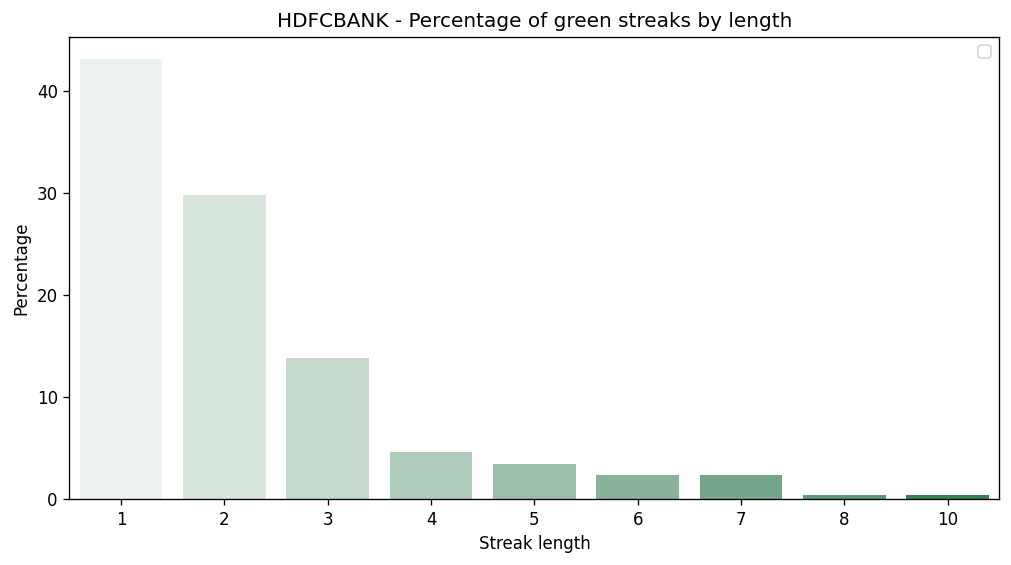

In [16]:
plt.figure(figsize = (10, 5), dpi = 120)

sns.countplot(
    x = stock_data.processed[g_streak_filter].groupby("StreakIndex")["Date"].count(),
    stat = "percent",
    hue = stock_data.processed[g_streak_filter].groupby("StreakIndex")["Date"].count(),
    palette = "light:seagreen"
)
plt.xlabel("Streak length")
plt.ylabel("Percentage")
plt.title(f"{STOCK_SYMBOL} - Percentage of green streaks by length")
plt.legend([])
plt.show()

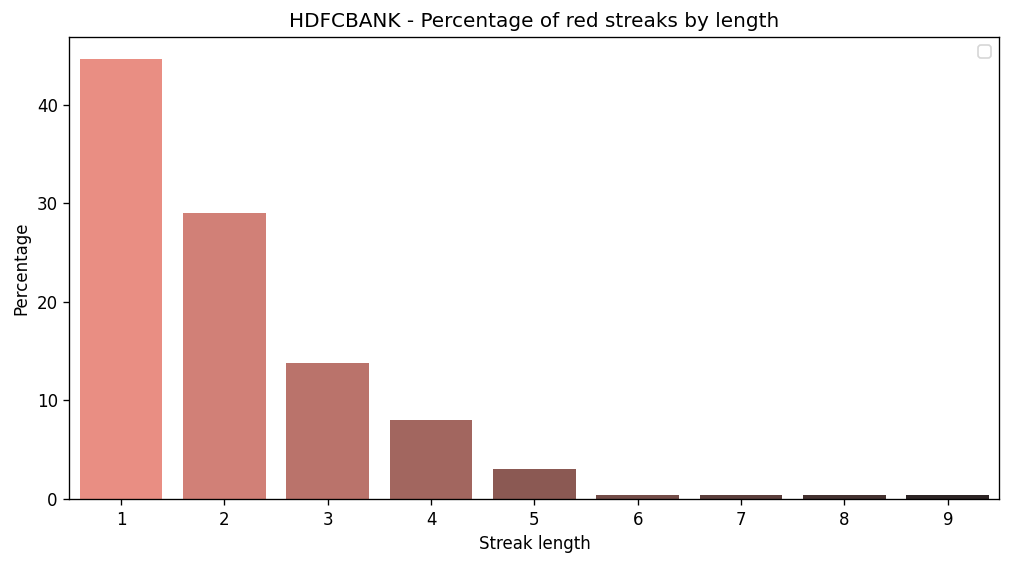

In [17]:
plt.figure(figsize = (10, 5), dpi = 120)

sns.countplot(
    x = stock_data.processed[~g_streak_filter].groupby("StreakIndex")["Date"].count(),
    stat = "percent",
    hue = stock_data.processed[~g_streak_filter].groupby("StreakIndex")["Date"].count(),
    palette = "dark:salmon_r"
)
plt.xlabel("Streak length")
plt.ylabel("Percentage")
plt.title(f"{STOCK_SYMBOL} - Percentage of red streaks by length")
plt.legend([])
plt.show()

### Current

#### First hit of current price

In [18]:
stock_data.get_first_hit(
    stock_data.processed.iloc[-1]["Close"]
)

Target: 1447.5
First hit: 2021-01-11 | 1214 days ago
'Close' at first hit: 1451.45
Total hits: 633


#### Adam Momentum

In [19]:
for i in [7, 15, 30, 60, 120]:
    am = adam_momentum(stock_data.processed["NR"].iloc[-i:].values)
    print(f"Last {i} trading days: {am:.4f}")

Last 7 trading days: -1.5102
Last 15 trading days: -0.8346
Last 30 trading days: -0.6284
Last 60 trading days: -0.4616
Last 120 trading days: -0.3107


### Trends

#### Stock Close Price

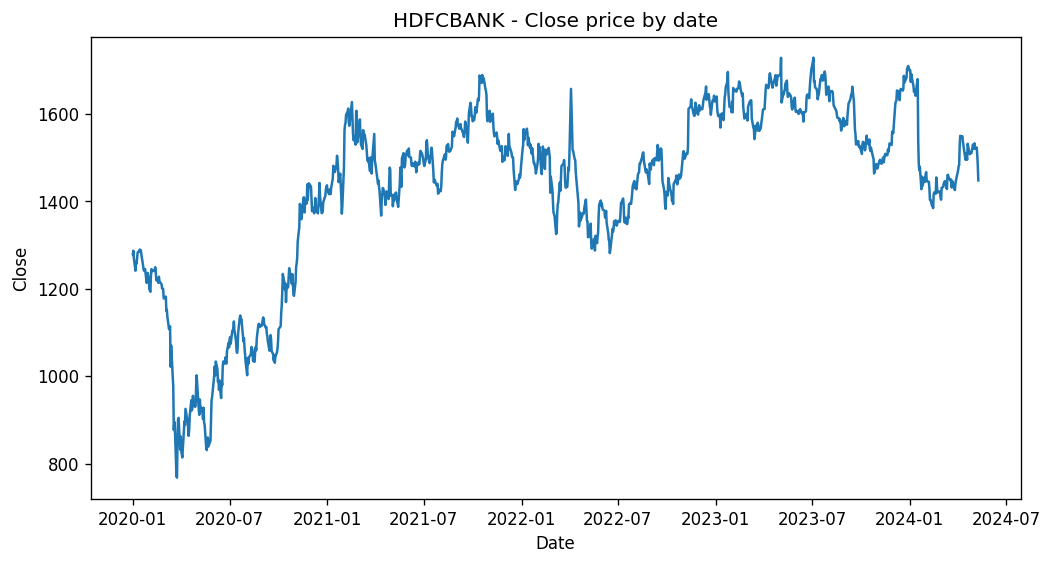

In [20]:
plt.figure(figsize = (10, 5), dpi = 120)
sns.lineplot(
    data = stock_data.processed,
    x = "Date",
    y = "Close"
)
plt.title(f"{STOCK_SYMBOL} - Close price by date")
plt.show()

#### PE

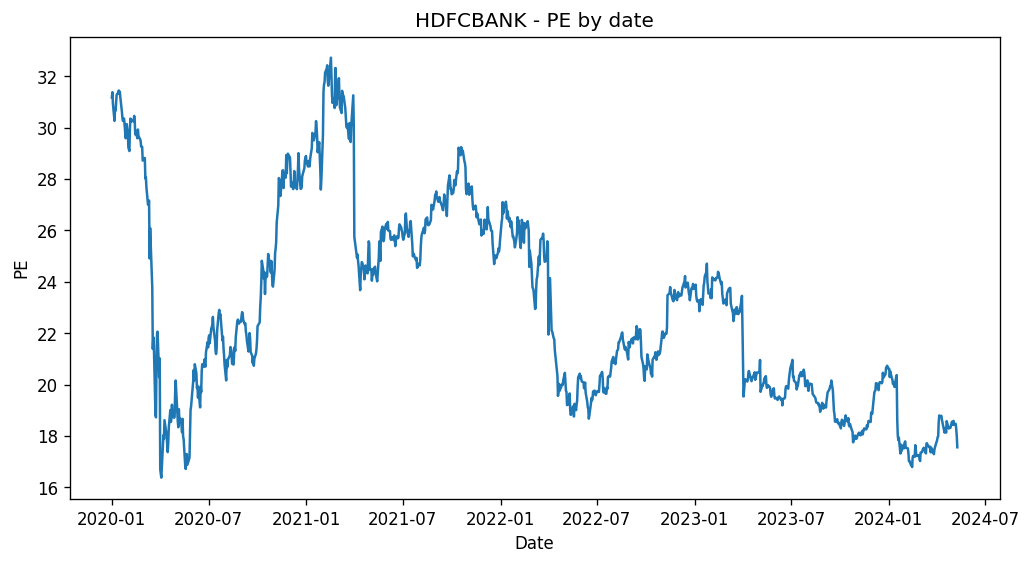

In [21]:
if "PE" in stock_data.processed.columns:
    plt.figure(figsize = (10, 5), dpi = 120)
    sns.lineplot(
        data = stock_data.processed,
        x = "Date",
        y = "PE"
    )
    plt.title(f"{STOCK_SYMBOL} - PE by date")
    plt.show()
else:
    print("PE data not available")